In [284]:
# Copyright [2025] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

# Load packages
import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import pickle

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

In [285]:
class Model:

    def __init__(self, eta, lam, gamma, mu):
        self.eta = eta #(m,2)
        self.m = eta.shape[0]
        self.weights = self.__init_weights(self.m) #(m,3)
        self.z = np.zeros((self.m,3))
        self.lam = lam
        self.gamma = gamma
        self.v = np.zeros((self.m,3))
        self.mu = mu

        eta_norm = np.linalg.norm(self.eta, axis=1)
        self.inv_eta_norm = np.diag(1/np.where(eta_norm > 0, eta_norm, 1)) # (m,m) diag
        

    def forward(self, s):
        return self.weights.T @ np.cos(np.pi*self.eta @ s) # (3,)

    def __init_weights(self, m):
        return np.zeros((m,3))
    
    def eps_greedy(self, s, eps):
        if np.random.rand() < 1-eps:
            return np.argmax(self.forward(s))
        else:
            return np.random.randint(3)

    def update_trace(self, s, a):
        self.z *= self.gamma*self.lam
        self.z[:, a] += np.cos(np.pi*self.eta @ s)
        self.z = np.clip(self.z, -5, 5)

    def Phi(self, s):
        return np.cos(np.pi*self.eta @ s)

    def Q(self,s,a):
        return (self.weights.T @ self.Phi(s))[a]

    def update_weights(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.weights +=  alpha*delta*(self.inv_eta_norm @ self.z)

    def update_weights_momentum(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.v
    
    def update_weights_nesterov(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
    

    def reset_trace(self):
        self.z = np.zeros((self.m,3))
        self.v = np.zeros((self.m,3))

    def save(self, file_name):
        d = {}
        d["N"] = self.eta
        d["W"] = self.weights.T

        with open(file_name, 'wb') as file:
            pickle.dump(d, file)

In [286]:

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x


In [287]:
# ----- good combos
# np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1]])
# -----

# np.array([[0,1], [0,2], [1, 0], [2, 0]])
# np.array([[0, 1], [0,0], [0, 2]])#random.np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([[0, 1], [0, 2], [1, 1], [2,2]]) #np.array([(i,j) for i in range(3) for j in range(3)]) # (m,2)

eta = np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1], [0,0]])
lam = 0.8 # for eligibility trace
gamma = 1.0 # discount factor
N_episodes = 200 # Number of episodes to run for training
EPS = 0.05 # base exploration rate
ALPHA = 0.003 # base learning rate

lr_lookback = 5 # learning rate reduction lookback
lr_threshold = -160 # threshold for learning rate reduction
# factor to multiply lr with if mean over last look_back episode rewards is less than lr_threshold:
lr_factor = 0.1

mu = 0.5 # SGD momentum/nesterov factor

In [288]:
params = {
    "eta": tuple(tuple(int(x) for x in row) for row in eta),
    "lam": lam,
    "gamma": gamma,
    "N_episodes": N_episodes,
    "EPS": EPS,
    "ALPHA": ALPHA,
    "lr_lookback": lr_lookback,
    "lr_threshold": lr_threshold,
    "lr_factor": lr_factor,
    "mu": mu
}

In [289]:
# Run 15 training runs with different random seeds
seeds = np.random.randint(0, 10000, size=15).tolist()
all_episode_rewards = []

for seed in seeds:
    np.random.seed(seed)
    
    model = Model(eta, lam, gamma, mu) 
    episode_reward_list = []

    # Training process
    for i in range(N_episodes):
        # Reset enviroment data
        done = False
        truncated = False
        state = scale_state_variables(env.reset(seed=seed + i)[0])
        total_episode_reward = 0.

        eps = EPS

        alpha = ALPHA
        if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
            alpha *= lr_factor

        model.reset_trace()
        action = model.eps_greedy(state, eps)

        while not (done or truncated):
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = scale_state_variables(next_state)

            next_action = model.eps_greedy(next_state, eps)

            model.update_trace(state, action)
            model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
            
            # Update episode reward
            total_episode_reward += reward
            
            # Update state for next iteration
            state = next_state
            action = next_action

        # Append episode reward
        episode_reward_list.append(total_episode_reward)

    all_episode_rewards.append(episode_reward_list)
    print(f"Seed {seed} done, final avg reward: {np.mean(episode_reward_list[-10:]):.1f}")

env.close()
    

Seed 3689 done, final avg reward: -125.9
Seed 8255 done, final avg reward: -113.5
Seed 3880 done, final avg reward: -127.3
Seed 351 done, final avg reward: -116.4
Seed 5546 done, final avg reward: -120.1
Seed 4009 done, final avg reward: -123.7
Seed 9527 done, final avg reward: -124.3
Seed 6468 done, final avg reward: -118.2
Seed 2819 done, final avg reward: -131.3
Seed 1693 done, final avg reward: -127.3
Seed 7975 done, final avg reward: -126.1
Seed 2715 done, final avg reward: -119.2
Seed 7658 done, final avg reward: -119.3
Seed 1519 done, final avg reward: -122.4
Seed 5840 done, final avg reward: -136.0


In [290]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [291]:
# UCB
# 1/(2*len(visited_states[0])) * np.sum(np.exp(-(np.array((0.5,0.5)) - visited_states[0])/2))

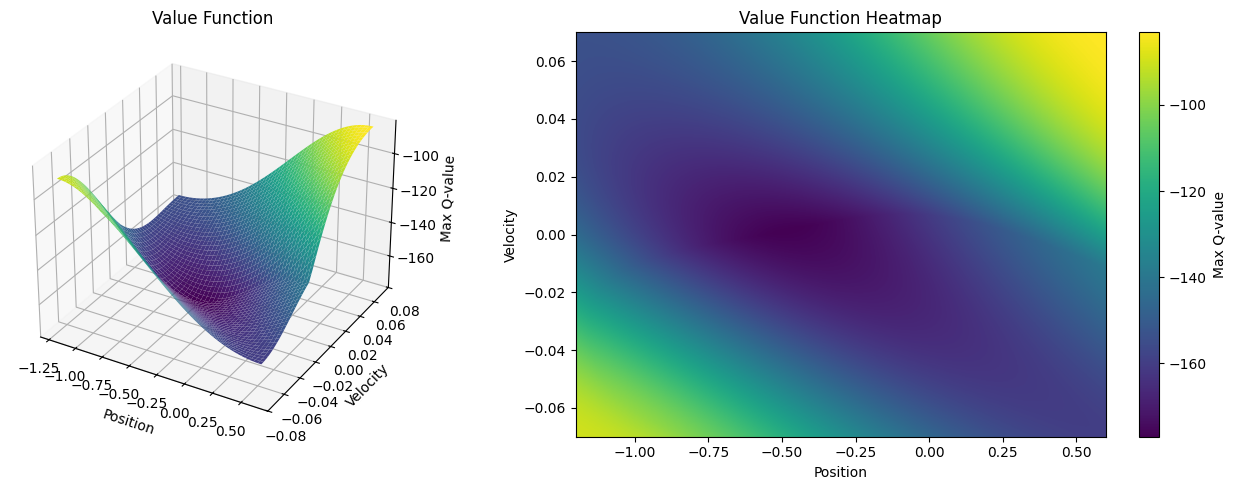

In [292]:
N = 500
# Use normalized coordinates for Q computation
x_norm = np.linspace(0, 1, N)
y_norm = np.linspace(0, 1, N)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)

# Original scale coordinates for plotting
x_orig = np.linspace(low[0], high[0], N)  # Position
y_orig = np.linspace(low[1], high[1], N)  # Velocity
X_orig, Y_orig = np.meshgrid(x_orig, y_orig)

# Compute Q-values over the grid and take max over actions
pts = np.vstack([X_norm.ravel(), Y_norm.ravel()])  # shape (2, N*N)
Phi_all = np.cos(np.pi * (model.eta @ pts))  # (m, N*N)
Q_all = model.weights.T @ Phi_all  # (3, N*N)
Z = np.max(Q_all, axis=0).reshape(X_norm.shape)

fig = plt.figure(figsize=(14, 5))

# 3D surface plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X_orig, Y_orig, Z, cmap='viridis')
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')
ax1.set_zlabel('Max Q-value')
ax1.set_title('Value Function')

# Heatmap
ax2 = fig.add_subplot(1, 2, 2)
im = ax2.imshow(Z, extent=[low[0], high[0], low[1], high[1]], origin='lower', aspect='auto', cmap='viridis')
ax2.set_xlabel('Position')
ax2.set_ylabel('Velocity')
ax2.set_title('Value Function Heatmap')
fig.colorbar(im, ax=ax2, label='Max Q-value')

fig.tight_layout()
plt.show()

/var/folders/z4/z52znr751d7gzxk5s8qjss140000gn/T/ipykernel_90384/948339780.py:45: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


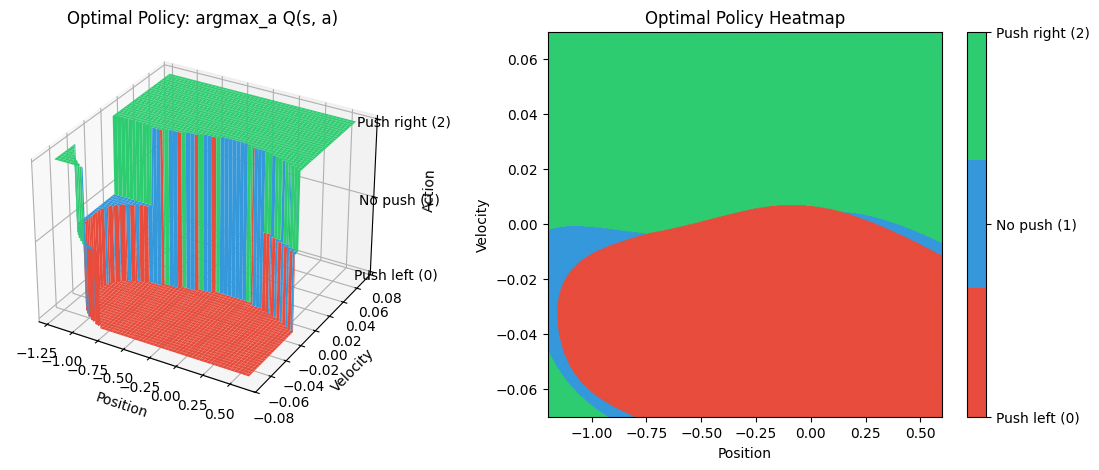

In [293]:
# Optimal policy plot (argmax of Q)
from matplotlib.colors import ListedColormap

N = 500
x_norm = np.linspace(0, 1, N)
y_norm = np.linspace(0, 1, N)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)

x_orig = np.linspace(low[0], high[0], N)
y_orig = np.linspace(low[1], high[1], N)
X_orig, Y_orig = np.meshgrid(x_orig, y_orig)

pts = np.vstack([X_norm.ravel(), Y_norm.ravel()])
Phi_all = np.cos(np.pi * (model.eta @ pts))
Q_all = model.weights.T @ Phi_all  # (3, N*N)
Z_policy = np.argmax(Q_all, axis=0).reshape(X_norm.shape)

# Custom colormap for 3 discrete actions
colors = ['#e74c3c', '#3498db', '#2ecc71']  # red, blue, green
cmap = ListedColormap(colors)
action_labels = ['Push left (0)', 'No push (1)', 'Push right (2)']

fig = plt.figure(figsize=(14, 5))

# 3D surface plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X_orig, Y_orig, Z_policy, cmap=cmap, vmin=0, vmax=2)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')
ax1.set_zlabel('Action')
ax1.set_zticks([0, 1, 2])
ax1.set_zticklabels(action_labels)
ax1.set_title('Optimal Policy: argmax_a Q(s, a)')

# Heatmap
ax2 = fig.add_subplot(1, 2, 2)
im = ax2.imshow(Z_policy, extent=[low[0], high[0], low[1], high[1]], origin='lower', 
                aspect='auto', cmap=cmap, vmin=0, vmax=2)
ax2.set_xlabel('Position')
ax2.set_ylabel('Velocity')
ax2.set_title('Optimal Policy Heatmap')
cbar = fig.colorbar(im, ax=ax2, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(action_labels)

fig.tight_layout()
plt.show()

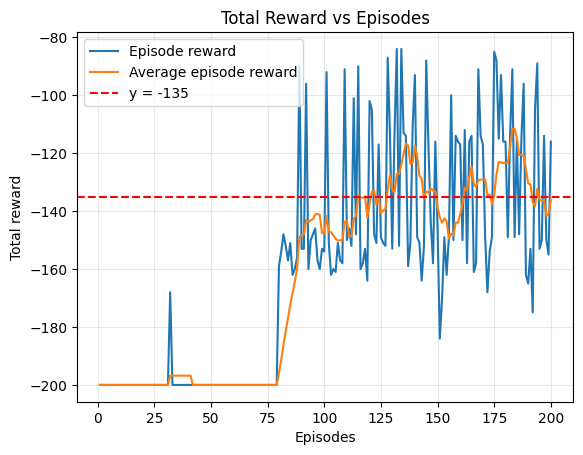

In [294]:
# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.axhline(-135, color='r', linestyle='--', label='y = -135')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
model.save("weights.pkl")

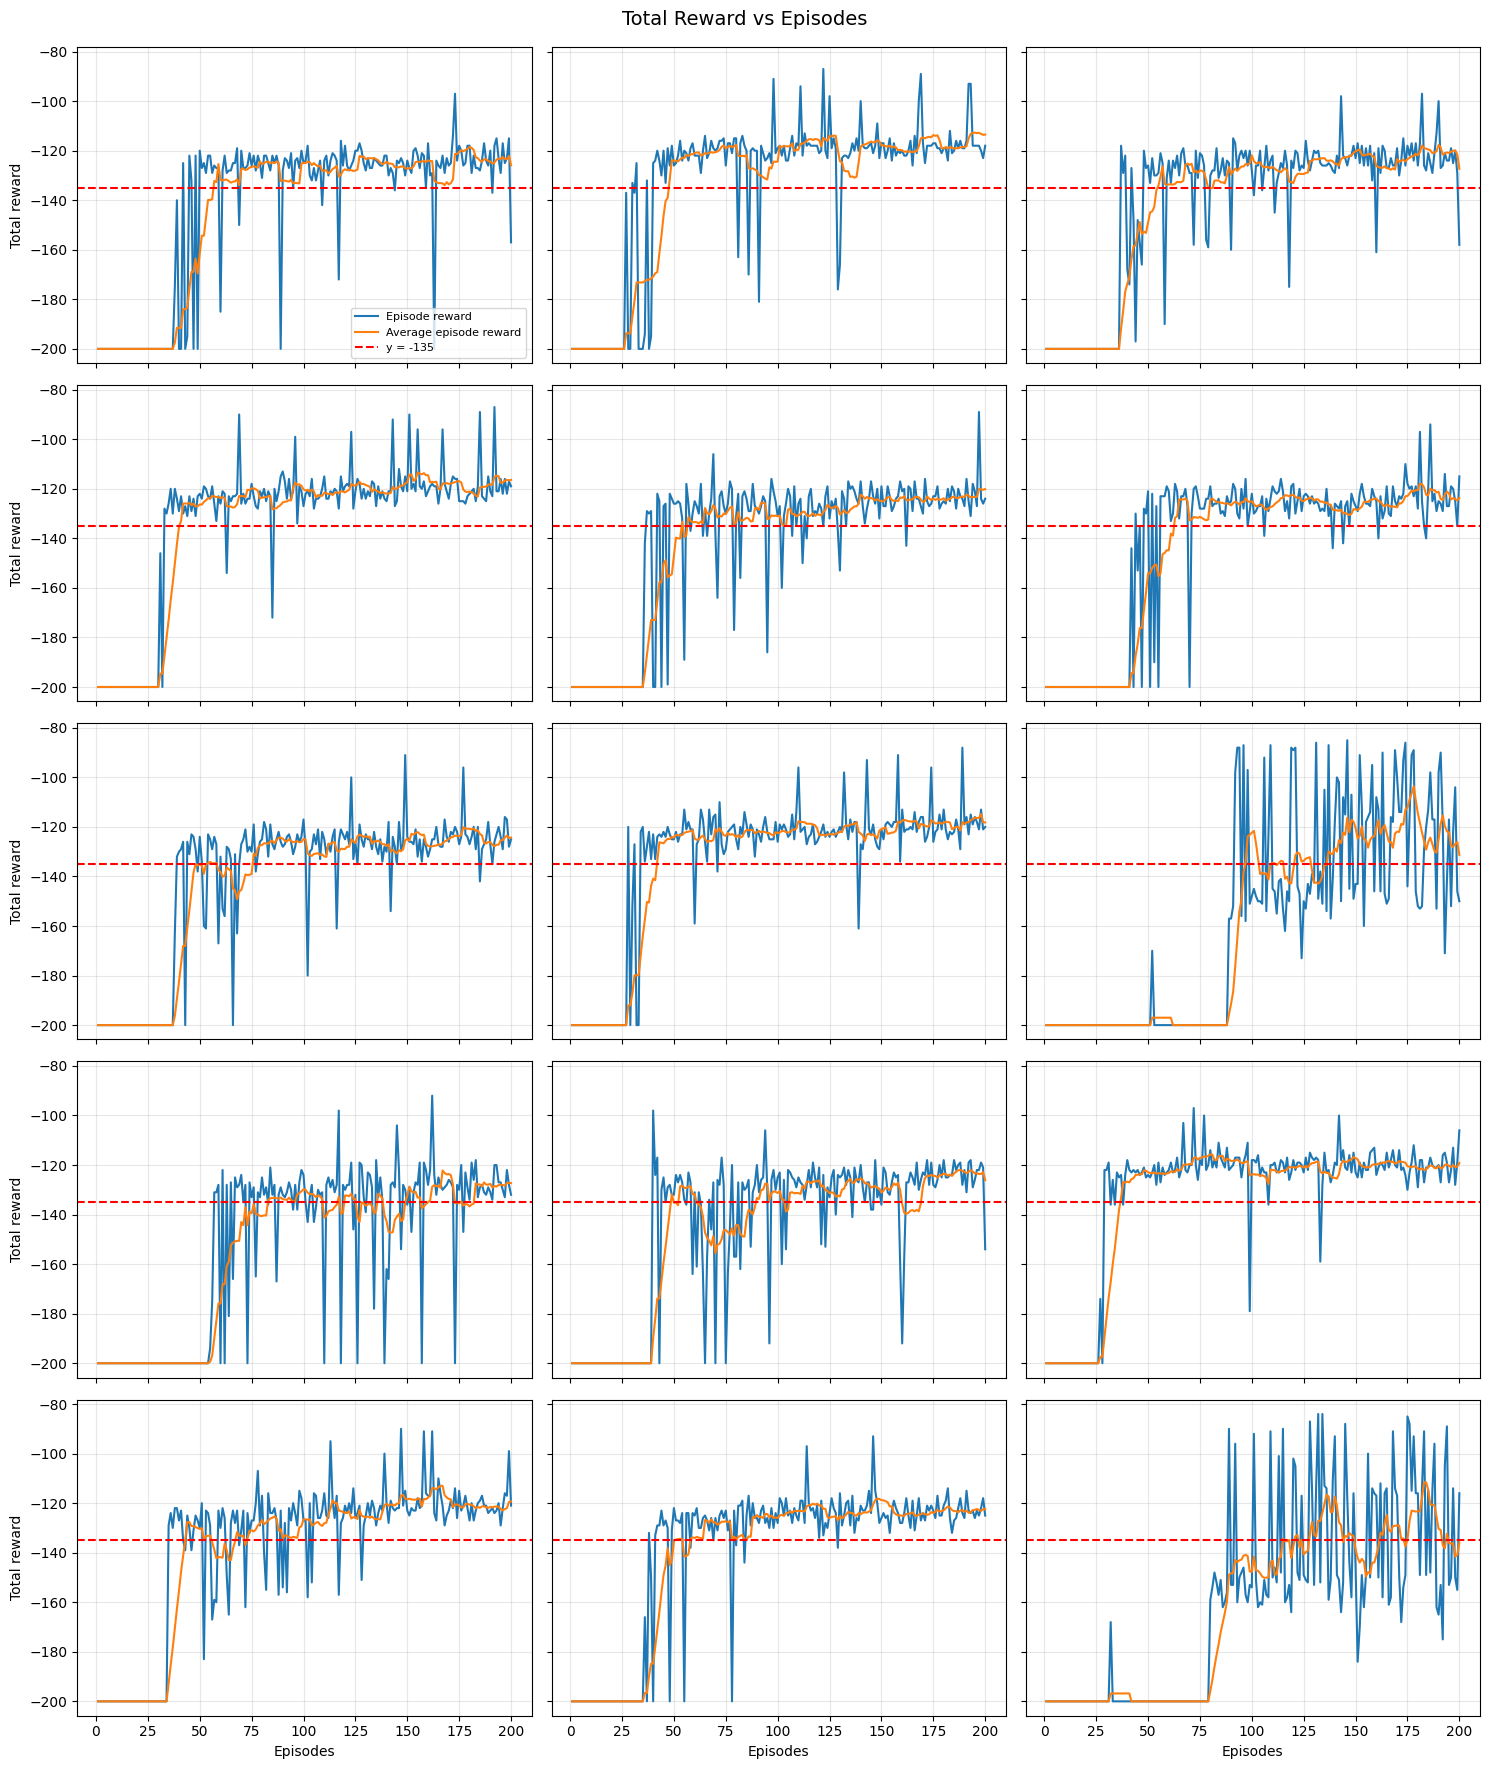

In [295]:
# Plot Rewards for all 15 runs in a 5x3 grid
fig, axes = plt.subplots(5, 3, figsize=(15, 18), sharex=True, sharey=True)
episodes = list(range(1, N_episodes + 1))

for idx, (ax, rewards) in enumerate(zip(axes.ravel(), all_episode_rewards)):
    ax.plot(episodes, rewards, label='Episode reward')
    ax.plot(episodes, running_average(rewards, 10), label='Average episode reward')
    ax.axhline(-135, color='r', linestyle='--', label='y = -135')
    ax.set_title(f'')
    ax.grid(alpha=0.3)
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel('Episodes')
for ax in axes[:, 0]:
    ax.set_ylabel('Total reward')

fig.suptitle('Total Reward vs Episodes\n', fontsize=14)
fig.tight_layout()
plt.show()

In [297]:
model.weights

array([[  27.29734952,   42.64241751,   45.55406689],
       [  -1.8828558 ,   -0.23052318,    1.01141978],
       [   6.48876598,    9.56376222,   10.18084838],
       [   3.79253738,   -0.87590608,   -1.85015089],
       [  17.07175616,   -6.43809718,  -11.74258377],
       [-144.95496442, -135.11981726, -133.11134224]])